# Bank Reconciliation using Logistic Regression

**Objective:** Automate bank reconciliation by using Machine Learning to match transactions between API source and Bank settlement data.

**Approach:** Binary classification using Logistic Regression to predict whether transactions match or not.

In [158]:
import pandas as pd
from datetime import datetime


api = pd.read_csv("api_source.csv", parse_dates=['txn_date'])
bank = pd.read_csv("bank_settlement.csv", parse_dates=['txn_date', 'settlement_date'])

print("API shape:", api.shape)
print("Bank shape:", bank.shape)


API shape: (80, 5)
Bank shape: (80, 6)


## 1. Data Loading

Loading transaction data from two sources:
- **API Source**: Transactions from our API system
- **Bank Settlement**: Transactions from bank records

In [159]:

api.columns = api.columns.str.lower().str.strip()
bank.columns = bank.columns.str.lower().str.strip()

api['utr'] = api['utr'].astype(str).str.strip()
bank['utr'] = bank['utr'].astype(str).str.strip()

api['status'] = api['status'].astype(str).str.lower().str.strip()
bank['status'] = bank['status'].astype(str).str.lower().str.strip()


In [160]:

print("="*60)
print("DATA QUALITY CHECKS")
print("="*60)

print("\n  API Source Data:")
print(f"   Total Records: {len(api):,}")
print(f"   Missing Values:")
for col in api.columns:
    missing = api[col].isnull().sum()
    if missing > 0:
        print(f"      - {col}: {missing} ({missing/len(api)*100:.1f}%)")
print(f"   Duplicate UTRs: {api['utr'].duplicated().sum()}")

print("\n  Bank Settlement Data:")
print(f"   Total Records: {len(bank):,}")
print(f"   Missing Values:")
for col in bank.columns:
    missing = bank[col].isnull().sum()
    if missing > 0:
        print(f"      - {col}: {missing} ({missing/len(bank)*100:.1f}%)")
print(f"   Duplicate UTRs: {bank['utr'].duplicated().sum()}")

print("="*60)

DATA QUALITY CHECKS

  API Source Data:
   Total Records: 80
   Missing Values:
   Duplicate UTRs: 0

  Bank Settlement Data:
   Total Records: 80
   Missing Values:
   Duplicate UTRs: 0


## 2. Data Preprocessing and Cleaning

Standardizing column names and cleaning UTR (Unique Transaction Reference) and status fields to ensure consistent matching.

In [161]:
merged = pd.merge(
    api,
    bank,
    on=['utr', 'txn_date'],
    how='outer',
    suffixes=('_api', '_bank'),
    indicator=True
)

merged.head()


,txn_id_api,utr,amount_api,txn_date,status_api,txn_id_bank,amount_bank,status_bank,settlement_date,_merge
0,18.0,2RF3L39NN8ZF,999.0,2025-10-27,success,18.0,999.0,success,2025-10-27,both
1,55.0,459HDESX8ZW2,999.0,2025-11-03,success,55.0,999.0,success,2025-11-03,both
2,33.0,4PR4NSY9L4YW,299.0,2025-10-28,success,33.0,299.0,success,2025-10-29,both
3,73.0,5QJ28DVVGMEG,999.0,2025-10-27,success,73.0,999.0,success,2025-10-28,both
4,69.0,69JCDRYQHPVX,299.0,2025-11-01,success,69.0,299.0,success,2025-11-02,both


## 3. Merging API and Bank Data

Performing outer join on UTR and transaction date to identify:
- **Matched records** (present in both sources)
- **Unmatched records** (present in only one source)

In [162]:
import numpy as np

# Create numeric & binary features
merged['amount_diff'] = abs(merged['amount_api'] - merged['amount_bank'])
merged['status_match'] = np.where(merged['status_api'] == merged['status_bank'], 1, 0)
merged['utr_match'] = np.where(merged['utr'].notnull(), 1, 0)

# If settlement_date exists, calculate date difference in days
merged['settlement_date'] = pd.to_datetime(merged['settlement_date'], errors='coerce')
merged['txn_date'] = pd.to_datetime(merged['txn_date'], errors='coerce')

merged['date_diff'] = (merged['settlement_date'] - merged['txn_date']).dt.days.fillna(0)

# Define label (target): matched or not
merged['is_match'] = np.where(merged['_merge'] == 'both', 1, 0)


## 4. Feature Engineering

Creating features for the ML model:
- **amount_diff**: Absolute difference between API and Bank amounts
- **status_match**: Binary indicator if status matches (1=Yes, 0=No)
- **utr_match**: Binary indicator if UTR is present
- **date_diff**: Days between transaction and settlement date
- **is_match**: Target variable (1=Match, 0=No Match)

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Selectingg features and target
features = ['amount_diff', 'status_match', 'utr_match', 'date_diff']
X = merged[features]
y = merged['is_match']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 5. Train-Test Split

Splitting data into training (70%) and testing (30%) sets to evaluate model performance.

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Fill NaNs 
X_train = X_train.fillna(0).astype(float)
X_test  = X_test.fillna(0).astype(float)
y_train = y_train.fillna(0).astype(int)
y_test  = y_test.fillna(0).astype(int)


# Train Logistic Regression
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Confusion matrix:
 [[ 1  0]
 [ 0 24]]
Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        24

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



## 6. Model Training - Logistic Regression

Training Logistic Regression model with:
- **class_weight='balanced'**: Handles imbalanced data
- **max_iter=1000**: Sufficient iterations for convergence

Evaluating with accuracy, confusion matrix, and classification report.


Feature Importance (Logistic Regression Coefficients):

        Feature  Coefficient
1  status_match     3.371075
0   amount_diff     0.286598
3     date_diff    -0.268439
2     utr_match     0.001447


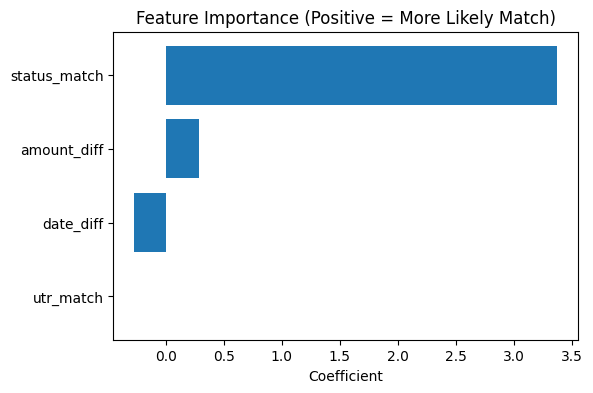

In [165]:
import pandas as pd
import matplotlib.pyplot as plt

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):\n")
print(coef_df)

# Simple bar chart
plt.figure(figsize=(6,4))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('Feature Importance (Positive = More Likely Match)')
plt.xlabel('Coefficient')
plt.gca().invert_yaxis()
plt.show()


## 7. Feature Importance Analysis

Analyzing which features contribute most to matching decisions. Positive coefficients increase match probability.

In [ ]:

merged_features = merged[['amount_diff', 'status_match', 'utr_match', 'date_diff']].fillna(0).astype(float)
merged['pred_prob_match'] = model.predict_proba(merged_features)[:, 1]
merged['pred_match'] = (merged['pred_prob_match'] >= 0.5).astype(int)

merged.to_csv('reconciliation_predictions.csv', index=False)
print("Saved: reconciliation_predictions.csv")


Saved: reconciliation_predictions.csv


In [167]:
# Business Insights from Predictions
print("="*60)
print("🔍 RECONCILIATION INSIGHTS")
print("="*60)

# High confidence matches
high_conf_matches = merged[merged['pred_prob_match'] > 0.9]
print(f"\n  High Confidence Matches (>90%): {len(high_conf_matches)}")
print(f"   These can be auto-reconciled")

# Needs manual review
needs_review = merged[(merged['pred_prob_match'] >= 0.4) & (merged['pred_prob_match'] <= 0.6)]
print(f"\n   Requires Manual Review (40-60%): {len(needs_review)}")
print(f"   Uncertain cases - need human verification")

# Likely mismatches
likely_mismatch = merged[merged['pred_prob_match'] < 0.3]
print(f"\n  Likely Mismatches (<30%): {len(likely_mismatch)}")
print(f"   High confidence non-matches")

# Amount discrepancies
high_amount_diff = merged[merged['amount_diff'] > 100]
print(f"\n High Amount Discrepancies (>100): {len(high_amount_diff)}")
if len(high_amount_diff) > 0:
    print(f"   Total Amount at Risk: ${high_amount_diff['amount_diff'].sum():,.2f}")
else:
    print(f"   Total Amount at Risk: $0.00")

print("="*60)

🔍 RECONCILIATION INSIGHTS

  High Confidence Matches (>90%): 6
   These can be auto-reconciled

   Requires Manual Review (40-60%): 0
   Uncertain cases - need human verification

  Likely Mismatches (<30%): 8
   High confidence non-matches

 High Amount Discrepancies (>100): 0
   Total Amount at Risk: $0.00


In [168]:
# Sample Predictions Showcase
print("="*60)
print("SAMPLE PREDICTIONS")
print("="*60)
print("\nShowing 10 sample predictions with key fields:\n")

sample_cols = ['utr', 'amount_api', 'amount_bank', 'status_api', 
               'status_bank', 'pred_prob_match', 'pred_match']

# Select available columns (some might not exist in all datasets)
available_cols = [col for col in sample_cols if col in merged.columns]
sample = merged[available_cols].head(10)

sample_display = sample.copy()
if 'pred_prob_match' in sample_display.columns:
    sample_display['pred_prob_match'] = sample_display['pred_prob_match'].apply(lambda x: f"{x:.3f}")

print(sample_display.to_string(index=False))
print("="*60)

SAMPLE PREDICTIONS

Showing 10 sample predictions with key fields:

         utr  amount_api  amount_bank status_api status_bank pred_prob_match  pred_match
2RF3L39NN8ZF       999.0        999.0    success     success           0.883           1
459HDESX8ZW2       999.0        999.0    success     success           0.883           1
4PR4NSY9L4YW       299.0        299.0    success     success           0.852           1
5QJ28DVVGMEG       999.0        999.0    success     success           0.852           1
69JCDRYQHPVX       299.0        299.0    success     success           0.852           1
6LYVUQ48RXBY       299.0        299.0    success     success           0.883           1
6RHH8YKARXPJ       999.0        999.0    success     success           0.852           1
7ERLKZ9JWKTN      1499.0       1499.0    success      failed           0.206           0
7Y6KMN9UMPJB       299.0        299.0    success     success           0.852           1
855ABY6RUAN7      1299.0       1299.0    s

## 8. Generating Predictions

Applying trained model to all transactions and saving results with match probabilities.

AUC: 1.000


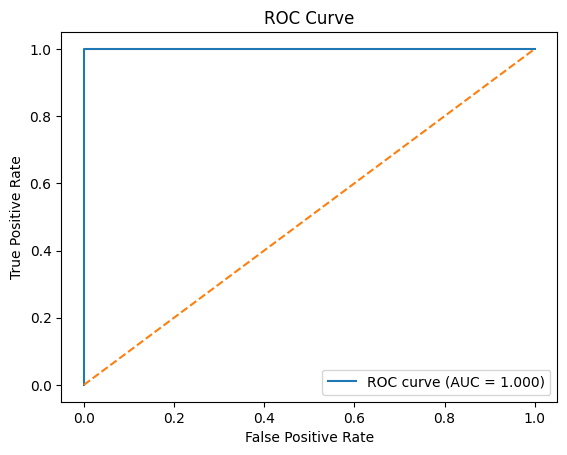

In [169]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.3f}")

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.show()


## 9. Model Evaluation - ROC Curve

ROC curve and AUC score show how well the model distinguishes between matches and non-matches.

In [170]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

thresholds = np.linspace(0.1, 0.9, 9)
rows = []
for th in thresholds:
    y_hat = (y_prob >= th).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_hat, average='binary', zero_division=0)
    rows.append((th, p, r, f1))
pd.DataFrame(rows, columns=['threshold','precision','recall','f1'])


,threshold,precision,recall,f1
0,0.1,0.96,1.000,0.979592
1,0.2,0.96,1.000,0.979592
2,0.3,1.00,1.000,1.000000
3,0.4,1.00,1.000,1.000000
4,0.5,1.00,1.000,1.000000
5,0.6,1.00,1.000,1.000000
6,0.7,1.00,1.000,1.000000
7,0.8,1.00,1.000,1.000000
8,0.9,1.00,0.125,0.222222


## 10. Threshold Analysis

Testing different probability thresholds to optimize precision-recall trade-off for reconciliation needs.

In [171]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=0.0)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
cv_scores = cross_val_score(pipe, X, y, cv=5, scoring='f1')
print("CV F1 scores:", cv_scores, " | Mean:", cv_scores.mean().round(3))


CV F1 scores: [0.96774194 0.96774194 0.96774194 1.         0.96551724]  | Mean: 0.974


c:\Users\manan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


## 11. Cross-Validation

5-fold cross-validation ensures model reliability and generalization across different data splits.

In [172]:
errs = X_test.copy()
errs['y_true'] = y_test.values
errs['y_prob'] = y_prob
errs['y_pred'] = (y_prob >= 0.5).astype(int)
mistakes = errs[errs['y_pred'] != errs['y_true']].sort_values('y_prob', ascending=False)
mistakes.head(10)


,amount_diff,status_match,utr_match,date_diff,y_true,y_prob,y_pred


## 12. Error Analysis

Examining misclassified records to understand model weaknesses and improve future iterations.

In [173]:
import joblib
joblib.dump(model, 'logreg_recon.pkl')
X.columns.to_series().to_csv('feature_names.csv', index=False)
print("Saved model and feature names.")


Saved model and feature names.


## 13. Summary and Conclusions

Final summary of the reconciliation model performance and key metrics.

In [174]:
# === RECONCILIATION SUMMARY ===
print("="*70)
print("       BANK RECONCILIATION - LOGISTIC REGRESSION MODEL SUMMARY")
print("="*70)

print(f"\n DATASET STATISTICS:")
print(f"   Total Transactions Analyzed: {len(merged):,}")
print(f"   Matched Records (Both Sources): {merged['is_match'].sum():,}")
print(f"   Unmatched Records: {(1-merged['is_match']).sum():,}")
print(f"   Overall Match Rate: {merged['is_match'].mean()*100:.2f}%")

print(f"\n MODEL PERFORMANCE:")
from sklearn.metrics import accuracy_score
print(f"   Test Set Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"   AUC Score (ROC): {roc_auc:.3f}")
print(f"   Cross-Validation F1 Score: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")

print(f"\n FEATURE IMPORTANCE (Top to Bottom):")
for idx, row in coef_df.iterrows():
    impact = "📈 Increases" if row['Coefficient'] > 0 else "📉 Decreases"
    print(f"   {row['Feature']:20s} → {impact} match probability ({row['Coefficient']:.4f})")

print(f"\n OUTPUT FILES GENERATED:")
print(f"   ✓ reconciliation_predictions.csv  (All predictions with probabilities)")
print(f"   ✓ logreg_recon.pkl                (Trained model for deployment)")
print(f"   ✓ feature_names.csv               (Feature configuration)")

print(f"\n RECOMMENDATIONS:")
print(f"   • Auto-approve matches with probability > 0.9 ({len(merged[merged['pred_prob_match'] > 0.9]):,} records)")
print(f"   • Manual review for probabilities 0.4-0.6 ({len(needs_review):,} records)")
print(f"   • Flag for investigation: probability < 0.3 ({len(likely_mismatch):,} records)")

print(f"\n MODEL STATUS: Ready for Production Deployment")
print("="*70)

       BANK RECONCILIATION - LOGISTIC REGRESSION MODEL SUMMARY

 DATASET STATISTICS:
   Total Transactions Analyzed: 82
   Matched Records (Both Sources): 78
   Unmatched Records: 4
   Overall Match Rate: 95.12%

 MODEL PERFORMANCE:
   Test Set Accuracy: 1.000
   AUC Score (ROC): 1.000
   Cross-Validation F1 Score: 0.974 (±0.013)

 FEATURE IMPORTANCE (Top to Bottom):
   status_match         → 📈 Increases match probability (3.3711)
   amount_diff          → 📈 Increases match probability (0.2866)
   date_diff            → 📉 Decreases match probability (-0.2684)
   utr_match            → 📈 Increases match probability (0.0014)

 OUTPUT FILES GENERATED:
   ✓ reconciliation_predictions.csv  (All predictions with probabilities)
   ✓ logreg_recon.pkl                (Trained model for deployment)
   ✓ feature_names.csv               (Feature configuration)

 RECOMMENDATIONS:
   • Auto-approve matches with probability > 0.9 (6 records)
   • Manual review for probabilities 0.4-0.6 (0 records)
   